In [47]:
from transformers import CLIPModel, CLIPFeatureExtractor, CLIPTokenizer
from datasets import load_dataset, Image, load_dataset_builder, load_from_disk
import torch
from typing import Callable, List, Optional, Union
import numpy as np
import pickle
import os

In [61]:
def preprocess_images(images: List[Image], feature_extractor: CLIPFeatureExtractor) -> torch.FloatTensor:
    """
    Preprocesses a list of images into a batch of tensors.

    Args:
        images (:obj:`List[Image.Image]`):
            A list of images to preprocess.

    Returns:
        :obj:`torch.FloatTensor`: A batch of tensors.
    """
    images = [np.array(image) for image in images]
#     print(images[0].shape)
    images = [(image + 1.) / 2. for image in images]
    images = feature_extractor(images, return_tensors="pt").pixel_values
    return images

def map_img_to_clip_feature(clip, feature_extractor, imgs, device="cuda"):
    for i, image in enumerate(imgs):
        if not image.mode == "RGB":
            imgs[i] = image.convert("RGB")
    retrieved_images = preprocess_images(imgs, feature_extractor).to(device)
    image_embeddings = clip.get_image_features(retrieved_images)
    image_embeddings = image_embeddings / torch.linalg.norm(image_embeddings, dim=-1, keepdim=True)
    image_embeddings = image_embeddings[None, ...]
    return image_embeddings
def map_txt_to_clip_feature(clip, tokenizer, prompt, device="cuda"):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids

    if text_input_ids.shape[-1] > tokenizer.model_max_length:
        removed_text = tokenizer.batch_decode(text_input_ids[:, tokenizer.model_max_length :])
        logger.warning(
            "The following part of your input was truncated because CLIP can only handle sequences up to"
            f" {tokenizer.model_max_length} tokens: {removed_text}"
        )
        text_input_ids = text_input_ids[:, :tokenizer.model_max_length]
    text_embeddings = clip.get_text_features(text_input_ids.to(device))
    text_embeddings = text_embeddings / torch.linalg.norm(text_embeddings, dim=-1, keepdim=True)
    text_embeddings = text_embeddings[:, None, :]
    return text_embeddings[0][0].cpu().detach().numpy()
def get_dataset_with_emb(dataset, clip_model, feature_extractor, device="cuda", img_col="image"):
    return dataset.map(lambda example: {'embeddings': map_img_to_clip_feature(clip_model, feature_extractor, [example[img_col]], device).cpu().detach().numpy()[0][0]})
class Retriever:
    def __init__(self, clip_model, feature_extractor, dataset, device="cuda", img_col="image"):
        self.dataset = dataset
        self.clip_model = clip_model.to(device)
        self.feature_extractor = feature_extractor
        if 'embeddings' not in self.dataset.features:
            self.dataset = get_dataset_with_emb(self.dataset, clip_model, feature_extractor, device, img_col)
        self.dataset.add_faiss_index(column='embeddings')
    def get_knn(self, vec, k=10):
        return self.dataset.get_nearest_examples('embeddings', vec, k=k)

In [3]:
clip_model = CLIPModel.from_pretrained("laion/CLIP-ViT-L-14-laion2B-s32B-b82K")

In [4]:
feature_extractor = CLIPFeatureExtractor.from_pretrained("laion/CLIP-ViT-L-14-laion2B-s32B-b82K")

In [51]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [27]:
dataset = load_dataset("pcuenq/oxford-pets", split="train")

Using custom data configuration pcuenq--oxford-pets-43375e644eed3d52
Found cached dataset parquet (D:/cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [37]:
emb_db_name = 'oxford_emb.hf'

In [43]:
if os.path.exists(emb_db_name):
    dataset = load_from_disk(emb_db_name)
else:
    dataset = get_dataset_with_emb(dataset, clip_model, feature_extractor)
    dataset.save_to_disk(emb_db_name)

In [45]:
retriever = Retriever(clip_model, feature_extractor, dataset)

  0%|          | 0/8 [00:00<?, ?it/s]

In [76]:
vec = map_txt_to_clip_feature(clip_model, tokenizer, "cat", device="cuda")

In [77]:
examples = retriever.get_knn(vec)

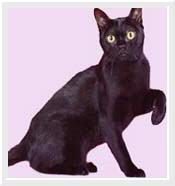

In [79]:
examples.examples['image'][0]

In [9]:
len(dataset['image'])

7390